In [1]:
import os
import pandas as pd
import numpy as np
import requests

# Data Import

In [2]:
os.chdir("/Volumes/GoogleDrive/My Drive/PROJECT/Data/Aging Biomarkers/European")

data1 = pd.read_csv('34187551-GCST90014288-GO_0007568.h.tsv.gz', sep='\t')
data2 = pd.read_csv('34187551-GCST90014289-GO_0007568.h.tsv.gz', sep='\t')
data3 = pd.read_csv('34187551-GCST90014290-GO_0007568.h.tsv.gz', sep='\t')
data4 = pd.read_csv('34187551-GCST90014292-GO_0007568.h.tsv.gz', sep='\t')

# Filtering

In [3]:
data1_filtered = data1.iloc[np.where(data1['p_value']<0.06)]
data2_filtered = data2.iloc[np.where(data2['p_value']<0.06)]
data3_filtered = data3.iloc[np.where(data3['p_value']<0.06)]
data4_filtered = data4.iloc[np.where(data4['p_value']<0.06)]

In [4]:
l1 = list(set(data1_filtered['hm_rsid']).intersection(data2_filtered['hm_rsid']))
l2 = list(set(l1).intersection(data3_filtered['hm_rsid']))
l3 = list(set(l2).intersection(data4_filtered['hm_rsid']))

In [5]:
snp_index = pd.DataFrame(l3).dropna()
print(snp_index)

               0
1      rs9861429
2      rs8092107
3      rs4905135
4     rs13232211
5     rs10400292
...          ...
7098  rs11128991
7099  rs12046244
7100   rs6910499
7101   rs7209195
7102   rs3004314

[7102 rows x 1 columns]


# Preparation

In [6]:
TRAIT_1 = data1[
    ['hm_other_allele','hm_effect_allele','beta','standard_error']
]
TRAIT_1=TRAIT_1.rename(columns={
                                    "hm_other_allele":"allele_0",
                                    "hm_effect_allele":"allele_1",
                                    "beta":"trait1_b",
                                    "standard_error":'trait1_se'})
TRAIT_1.index = data1.hm_rsid
TRAIT_1 = TRAIT_1.loc[list(snp_index[0])]

In [7]:
TRAIT_2 = data2[
    ['beta','standard_error']
]

TRAIT_2.index = data2.hm_rsid
TRAIT_2 = TRAIT_2.loc[list(snp_index[0])]

In [8]:
TRAIT_3 = data3[
    ['beta','standard_error']
]

TRAIT_3.index = data3.hm_rsid
TRAIT_3 = TRAIT_3.loc[list(snp_index[0])]

In [9]:
TRAIT_4 = data4[
    ['beta','standard_error']
]

TRAIT_4.index = data4.hm_rsid
TRAIT_4 = TRAIT_4.loc[list(snp_index[0])]

# Combination

In [10]:
S_XY = TRAIT_1
S_XY['trait2_b']=TRAIT_2['beta']
S_XY['trait2_se']=TRAIT_2['standard_error']
S_XY['trait3_b']=TRAIT_3['beta']
S_XY['trait3_se']=TRAIT_3['standard_error']
S_XY['trait4_b']=TRAIT_4['beta']
S_XY['trait4_se']=TRAIT_4['standard_error']

In [11]:
S_XY

,allele_0,allele_1,trait1_b,trait1_se,trait2_b,trait2_se,trait3_b,trait3_se,trait4_b,trait4_se
hm_rsid,,,,,,,,,,
rs9861429,T,C,-0.1425,0.0569,-0.1680,0.0563,-0.1812,0.0576,-0.2294,0.0726
rs8092107,C,T,-0.0711,0.0308,-0.0582,0.0301,-0.0614,0.0311,-0.1354,0.0389
rs4905135,C,T,-0.1373,0.0625,-0.2236,0.0620,-0.1527,0.0634,-0.3232,0.0784
rs13232211,A,C,0.1036,0.0329,0.0783,0.0322,0.0692,0.0332,0.1126,0.0412
rs10400292,A,G,-0.0731,0.0307,-0.0606,0.0302,-0.0728,0.0310,-0.0863,0.0386
...,...,...,...,...,...,...,...,...,...,...
rs11128991,G,A,0.0684,0.0299,0.0578,0.0295,0.0609,0.0304,0.0767,0.0379
rs12046244,G,C,-0.0932,0.0367,-0.0974,0.0363,-0.0865,0.0375,-0.1306,0.0466
rs6910499,A,G,0.0801,0.0345,0.0721,0.0337,0.0736,0.0349,0.0997,0.0435


# S_XY Export

In [104]:
S_XY.to_csv('S_XY_European.csv',index=True)

# Results Import

In [115]:
results = pd.read_csv('Results.csv',index_col=0)

In [197]:
p_values = 10**(-results['-log10(p-val)'])
print("Number of significant associations BEFORE correction: ",len(p_values.iloc[np.where(p_values<0.05)]))

Number of significant associations BEFORE correction:  5859


# Bonferroni correction

In [195]:
adjusted_p_values=p_values*len(data1)
p_values_corrected = adjusted_p_values.iloc[np.where(adjusted_p_values<0.05)]
print("Number of significant associations AFTER correction: ",len(p_values_corrected))

Number of significant associations AFTER correction:  1728


# Published Associations

In [154]:
response = requests.get('https://www.ebi.ac.uk/gwas/rest/api/efoTraits/GO_0007568/associations')
GWAS_EBI=response.json()

In [194]:
published_snps=[]
for i in range(len(GWAS_EBI['_embedded']['associations'])):
    published_snps.append(GWAS_EBI['_embedded']['associations'][i]['loci'][0]['strongestRiskAlleles'][0]['riskAlleleName'])
    
print("Number of PUBLISHED significant associations: ",len(published_snps))

Number of PUBLISHED significant associations:  209


In [220]:
#print('Published SNPS with significant associations: \n\n',published_snps)

# Plotting

Text(0.5, 0, 'RefSNP ID')

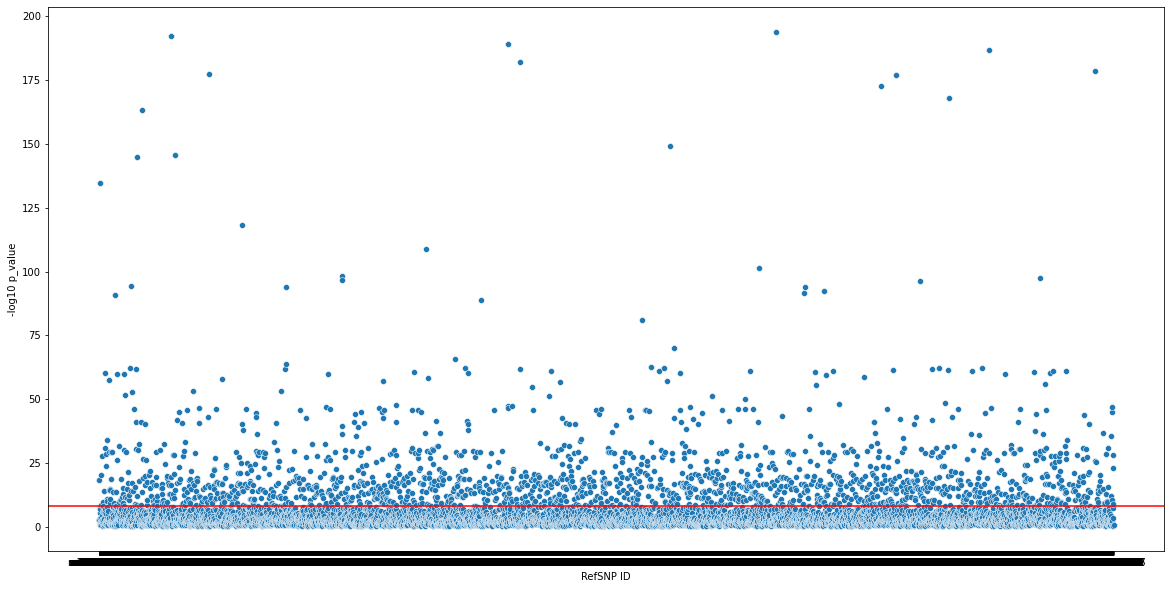

In [219]:
import seaborn as sns
plt.figure(figsize=(20,10))
sns.scatterplot(x=p_values.index,y=-np.log10(p_values))
plt.axhline(y = -np.log10(0.05/len(data1)), color = 'r', linestyle = '-')
plt.ylabel('-log10 p_value')
plt.xlabel('RefSNP ID')